Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/quickstart/azureml-quickstart.png)

# Tutorial: Azure Machine Learning Quickstart

In this tutorial, you learn how to quickly get started with Azure Machine Learning. Using  a *compute instance* - a fully managed cloud-based VM that is pre-configured with the latest data science tools - you will train an image classification model using the CIFAR10 dataset.

In this tutorial you will learn how to:

* Create a compute instance and attach to a notebook
* Train an image classification model and log metrics
* Deploy the model

## Prerequisites

1. An Azure Machine Learning workspace
1. Familiar with the Python language and machine learning workflows.


## Create compute & attach to notebook

To run this notebook you will need to create an Azure Machine Learning _compute instance_. The benefits of a compute instance over a local machine (e.g. laptop) or cloud VM are as follows:

* It is a pre-configured with all the latest data science libaries (e.g. panads, scikit, TensorFlow, PyTorch) and tools (Jupyter, RStudio). In this tutorial we make extensive use of PyTorch, AzureML SDK, matplotlib and we do not need to install these components on a compute instance.
* Notebooks are seperate from the compute instance - this means that you can develop your notebook on a small VM size, and then seamlessly scale up (and/or use a GPU-enabled) the machine when needed to train a model.
* You can easily turn on/off the instance to control costs. 

To create compute, click on the + button at the top of the notebook viewer in Azure Machine Learning Studio:

<img src="https://dsvmamlstorage127a5f726f.blob.core.windows.net/images/ci-create.PNG" width="500"/>

This will pop up the __New compute instance__ blade, provide a valid __Compute name__ (valid characters are upper and lower case letters, digits, and the - character). Then click on __Create__. 

It will take approximately 3 minutes for the compute to be ready. When the compute is ready you will see a green light next to the compute name at the top of the notebook viewer:

<img src="https://dsvmamlstorage127a5f726f.blob.core.windows.net/images/ci-create2.PNG" width="500"/>

You will also notice that the notebook is attached to the __Python 3.6 - AzureML__ jupyter Kernel. Other kernels can be selected such as R. In addition, if you did have other instances you can switch to them by simply using the dropdown menu next to the Compute label.


## Import Data

For this tutorial, you will use the CIFAR10 dataset. It has the classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. The images in CIFAR-10 three-channel color images of 32x32 pixels in size.

The code cell below uses the PyTorch API to download the data to your compute instance, which should be quick (around 15 seconds). The data is divided into training and test sets.

* **NOTE: The data is downloaded to the compute instance (in the `/tmp` directory) and not a durable cloud-based store like Azure Blob Storage or Azure Data Lake. This means if you delete the compute instance the data will be lost. The [getting started with Azure Machine Learning tutorial series](https://docs.microsoft.com/azure/machine-learning/tutorial-1st-experiment-sdk-setup-local) shows how to create an Azure Machine Learning *dataset*, which aids durability, versioning, and collaboration.**

In [12]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/tmp/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/tmp/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
import os
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/sbirk-aml-ci/code/Users/s.birk/Samples/1.18.0/tutorials/quickstart'

## Take a look at the data
In the following cell, you have some python code that displays the first batch of 4 CIFAR10 images:

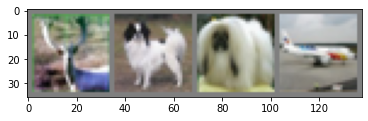

 deer   dog   dog plane


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Train model and log metrics

In the directory `model` you will see a file called [model.py](./model/model.py) that defines the neural network architecture. The model is trained using the code below.

* **Note: The model training take around 4 minutes to complete. The benefit of a compute instance is that the notebooks are separate from the compute - therefore you can easily switch to a different size/type of instance. For example, you could switch to run this training on a GPU-based compute instance if you had one provisioned. In the code below you can see that we have included `torch.device("cuda:0" if torch.cuda.is_available() else "cpu")`, which detects whether you are using a CPU or GPU machine.**

In [ ]:
from model.model import Net
from azureml.core import Experiment
from azureml.core import Workspace

ws = Workspace.from_config()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

exp = Experiment(workspace=ws, name="cifar10-experiment")
run = exp.start_logging(snapshot_directory=None)

# define convolutional network
net = Net()
net.to(device)

# set up pytorch loss /  optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

run.log("learning rate", 0.001)
run.log("momentum", 0.9)

# train the network
for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # unpack the data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            loss = running_loss / 2000
            run.log("loss", loss)
            print(f'epoch={epoch + 1}, batch={i + 1:5}: loss {loss:.2f}')
            running_loss = 0.0

print('Finished Training')

Once you have executed the cell below you can view the metrics updating in real time in the Azure Machine Learning studio:

1. Select **Experiments** (left-hand menu)
1. Select **cifar10-experiment**
1. Select **Run 1**
1. Select the **Metrics** Tab

The metrics tab will display the following graph:

<img src="https://dsvmamlstorage127a5f726f.blob.core.windows.net/images/metrics-capture.PNG" alt="dataset details" width="500"/>

#### Understand the code

The code is based on the [Pytorch 60minute Blitz](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) where we have also added a few additional lines of code to track the loss metric as the neural network trains.

| Code       | Description     | 
| ------------- | ---------- |
|  `experiment =  Experiment( ... )` | [Experiment](https://docs.microsoft.com/python/api/azureml-core/azureml.core.experiment.experiment?view=azure-ml-py&preserve-view=true) provides a simple way to organize multiple runs under a single name. Later you can see how experiments make it easy to compare metrics between dozens of runs.   |
| `run.log()`   | This will log the metrics to Azure Machine Learning. |

## Version control models with the Model Registry

You can use model registration to store and version your models in your workspace. Registered models are identified by name and version. Each time you register a model with the same name as an existing one, the registry increments the version. Azure Machine Learning supports any model that can be loaded through Python 3.

The code below does:

1. Saves the model on the compute instance
1. Uploads the model file to the run (if you look in the experiment on Azure Machine Learning studio you should see on the **Outputs + logs** tab the model has been saved in the run)
1. Registers the uploaded model file
1. Transitions the run to a completed state

In [ ]:
from azureml.core import Model

PATH = 'cifar_net.pth'
torch.save(net.state_dict(), PATH)

run.upload_file(name=PATH, path_or_stream=PATH)
model = run.register_model(model_name='cifar10-model', 
                                model_path=PATH,
                                model_framework=Model.Framework.PYTORCH,
                                description='cifar10 model')
            
run.complete()

### View model in the model registry

You can see the stored model by navigating to **Models** in the left-hand menu bar of Azure Machine Learning Studio. Click on the **cifar10-model** and you can see the details of the model like the experiement run id that created the model.

## Deploy the model

The next cell deploys the model to an Azure Container Instance so that you can score data in real-time (Azure Machine Learning also provides mechanisms to do batch scoring). A real-time endpoint allows application developers to integrate machine learning into their apps.

* **Note: The deployment takes around 3 minutes to complete.**

In [ ]:
from azureml.core import Environment, Model
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice

environment = Environment.get(ws, "AzureML-PyTorch-1.6-CPU")
model = Model(ws, "cifar10-model")

service_name = 'cifar-service'
inference_config = InferenceConfig(entry_script='score.py', environment=environment)
aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)

service = Model.deploy(workspace=ws,
                       name=service_name,
                       models=[model],
                       inference_config=inference_config,
                       deployment_config=aci_config,
                       overwrite=True)
service.wait_for_deployment(show_output=True)

### Understand the code

| Code       | Description     | 
| ------------- | ---------- |
|  `environment = Environment.get()` | [Environment](https://docs.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py#environment) specify the Python packages, environment variables, and software settings around your training and scoring scripts. In this case, you are using a *curated environment* that has all the packages to run PyTorch.   |
|  `inference_config = InferenceConfig()`   | This specifies the inference (scoring) configuration for the deployment such as the script to use when scoring (see below) and on what environment. |
| `service = Model.deploy()` | Deploy the model. |

The [*scoring script*](score.py) file is has two functions:

1. an `init` function that executes once when the service starts - in this function you normally get the model from the registry and set global variables
1. a `run(data)` function that executes each time a call is made to the service. In this function, you normally deserialize the json, run a prediction and output the predicted result.


## Test the model service

In the next cell, you get some unseen data from the test loader:

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Finally, the next cell runs scores the above images using the deployed model service.

In [ ]:
import json

input_payload = json.dumps({
    'data': images.tolist()
})

output = service.run(input_payload)
print(output)

## Clean up resources

To clean up the resources after this quickstart, firstly delete the Model service using:

In [ ]:
service.delete()

Next stop the compute instance by following these steps:

1. Go to **Compute** in the left-hand menu of the Azure Machine Learning studio
1. Select your compute instance
1. Select **Stop**


**Important: The resources you created can be used as prerequisites to other Azure Machine Learning tutorials and how-to articles.** If you don't plan to use the resources you created, delete them, so you don't incur any charges:

1. In the Azure portal, select **Resource groups** on the far left.
1. From the list, select the resource group you created.
1. Select **Delete resource group**.
1. Enter the resource group name. Then select **Delete**.

You can also keep the resource group but delete a single workspace. Display the workspace properties and select **Delete**.

## Next Steps

In this tutorial, you have seen how to run your machine learning code on a fully managed, pre-configured cloud-based VM called a *compute instance*. Having a compute instance for your development environment removes the burden of installing data science tooling and libraries (for example, Jupyter, PyTorch, TensorFlow, Scikit) and allows you to easily scale up/down the compute power (RAM, cores) since the notebooks are separated from the VM. 

It is often the case that once you have your machine learning code working in a development environment that you want to productionize this by running as a **_job_** - ideally on a schedule or trigger (for example, arrival of new data). To this end, we recommend that you follow [**the day 1 getting started with Azure Machine Learning tutorial**](https://docs.microsoft.com/azure/machine-learning/tutorial-1st-experiment-sdk-setup-local). This day 1 tutorial is focussed on running jobs-based machine learning code in the cloud.